In [ ]:
from google.colab import drive
drive.mount('/content/drive')

📊 Évaluation sur la dernière année (naïve simple) :
MAE  : 23.89
RMSE : 26.68
MAPE : 11.27%


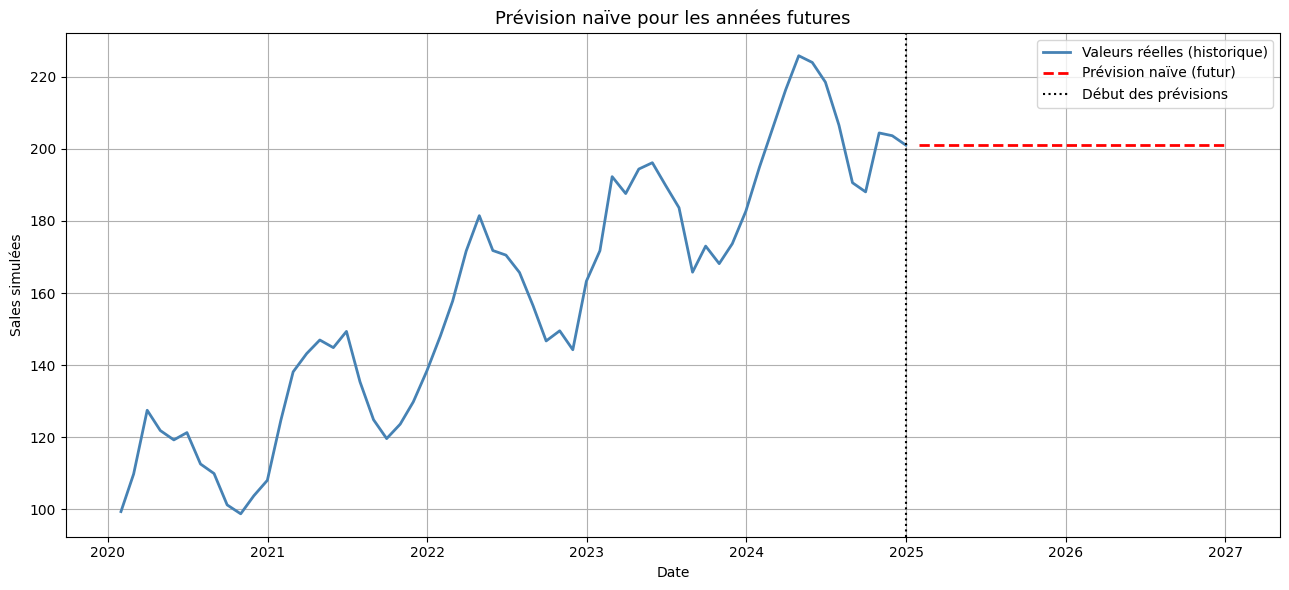

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ----------------------------------------------------
# 🔹 Données (ta partie reste la même)
# ----------------------------------------------------
n = 60           # 5 ans mensuels
t = np.arange(n)
beta0 = 100
beta1 = 2
A = 20
P = 12
sigma = 5

trend = beta0 + beta1 * t
seasonality = A * np.sin(2 * np.pi * t / P)
noise = np.random.normal(0, sigma, n)
sales = trend + seasonality + noise

dates = pd.date_range(start='2020-01-01', periods=n, freq='ME')
data = pd.DataFrame({'Date': dates, 'Sales': sales})

# ----------------------------------------------------
# 🔹 Naive model: forecast future years
# ----------------------------------------------------
horizon_months = 24  # Prévoir 2 ans de plus
future_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.offsets.MonthEnd(1),
                             periods=horizon_months, freq='ME')

# Prévision naïve = dernière valeur connue répétée
last_value = data['Sales'].iloc[-1]
future_preds = np.repeat(last_value, horizon_months)

# Créer DataFrame des prévisions
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_preds})

# ----------------------------------------------------
# 🔹 Évaluation (optionnel si tu veux comparer sur un test)
# ----------------------------------------------------
# Exemple : comparer naïve sur les 12 derniers mois du dataset existant
train = data.iloc[:-12]
test = data.iloc[-12:]
naive_test_preds = np.repeat(train['Sales'].iloc[-1], len(test))

mae = mean_absolute_error(test['Sales'], naive_test_preds)
rmse = np.sqrt(mean_squared_error(test['Sales'], naive_test_preds))
mape = np.mean(np.abs((test['Sales'] - naive_test_preds) / test['Sales'])) * 100

print("📊 Évaluation sur la dernière année (naïve simple) :")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

# ----------------------------------------------------
# 🔹 Visualisation
# ----------------------------------------------------
plt.figure(figsize=(13,6))
plt.plot(data['Date'], data['Sales'], label='Valeurs réelles (historique)', color='steelblue', linewidth=2)
plt.plot(future_df['Date'], future_df['Forecast'], label='Prévision naïve (futur)', color='red', linestyle='--', linewidth=2)
plt.axvline(x=data['Date'].iloc[-1], color='black', linestyle=':', label='Début des prévisions')
plt.title("Prévision naïve pour les années futures", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Sales simulées")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Évaluation du modèle naïf :
MAE  : 8.39
RMSE : 9.93
MAPE : 4.10%


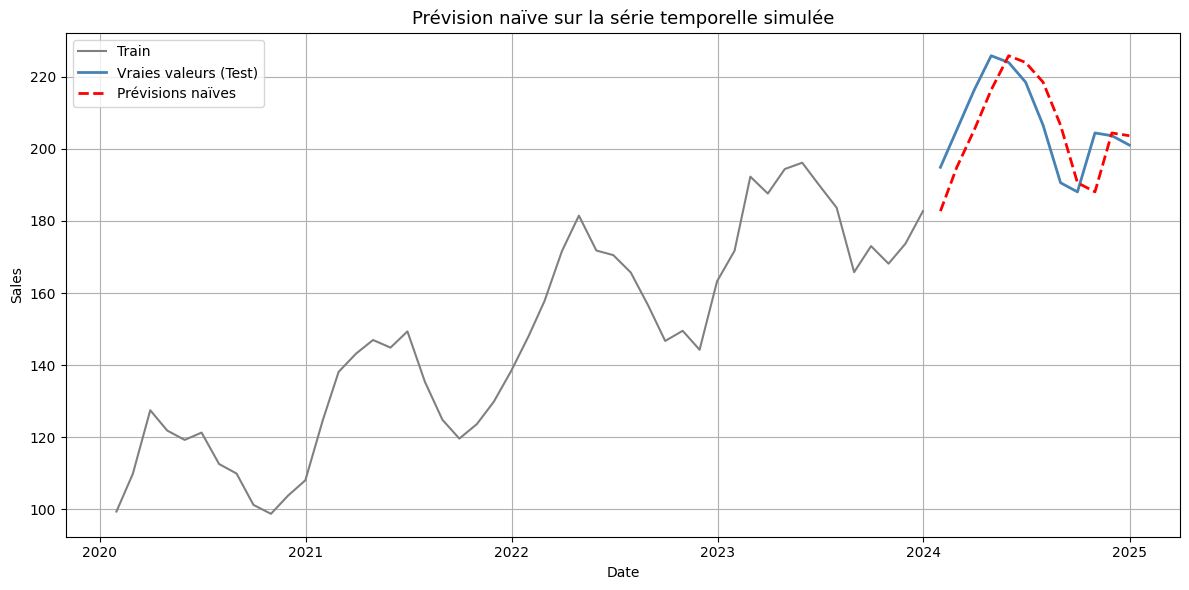

In [4]:
# ======================================================
# 🔹 Modèle naïf et évaluation
# ======================================================
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ----------------------------
# Découpage train / test
# ----------------------------
train_size = int(0.8 * len(data))
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# ----------------------------
# Modèle naïf : la prévision = dernière valeur observée
# ----------------------------
# On décale simplement la série d'un pas
naive_forecast = train['Sales'].iloc[-1]
naive_preds = [train['Sales'].iloc[-1]] * len(test)

# OU (version plus générale)
naive_preds = test['Sales'].shift(1)
naive_preds.iloc[0] = train['Sales'].iloc[-1]

# ----------------------------
# Évaluation des performances
# ----------------------------
mae = mean_absolute_error(test['Sales'], naive_preds)
rmse = np.sqrt(mean_squared_error(test['Sales'], naive_preds))
mape = np.mean(np.abs((test['Sales'] - naive_preds) / test['Sales'])) * 100

print("Évaluation du modèle naïf :")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

# ----------------------------
# Visualisation : prévisions vs réels
# ----------------------------
plt.figure(figsize=(12,6))
plt.plot(train['Date'], train['Sales'], label='Train', color='gray')
plt.plot(test['Date'], test['Sales'], label='Vraies valeurs (Test)', color='steelblue', linewidth=2)
plt.plot(test['Date'], naive_preds, label='Prévisions naïves', color='red', linestyle='--', linewidth=2)
plt.title("Prévision naïve sur la série temporelle simulée", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


📊 ÉVALUATION COMPARATIVE
--------------------------------------
🔸 Modèle Naïf
MAE  : 23.89
RMSE : 26.68
MAPE : 11.27%
--------------------------------------
🔹 Régression Linéaire
MAE  : 13.75
RMSE : 16.28
MAPE : 6.53%


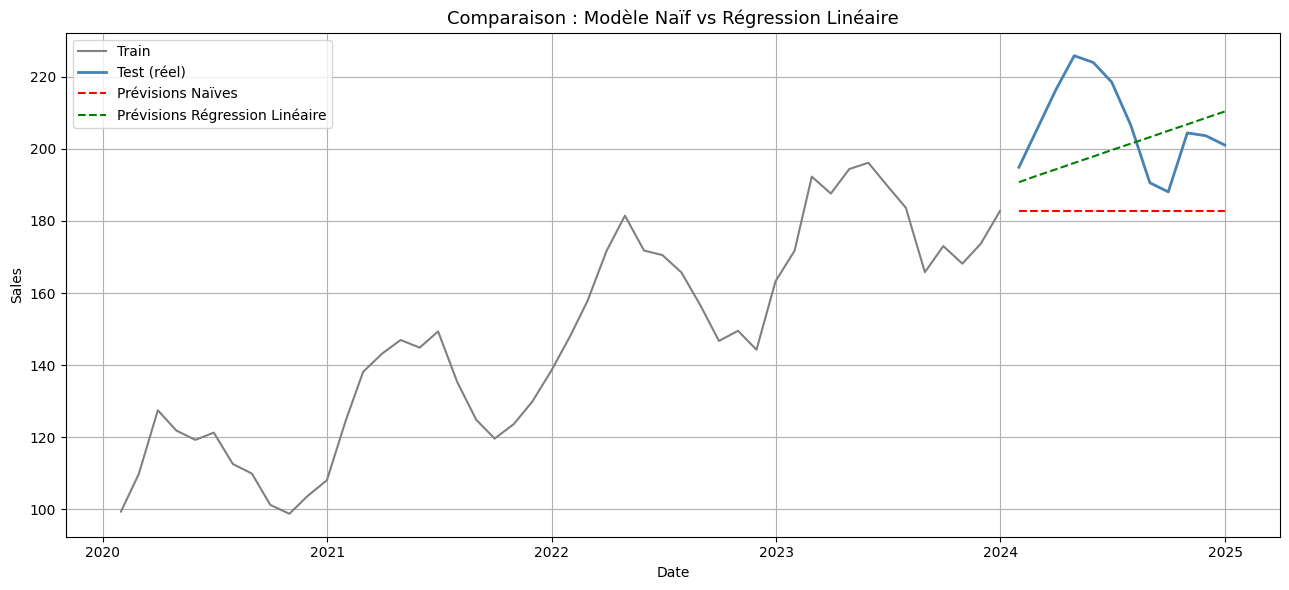

In [5]:
# ======================================================
# 🔹 Modèle linéaire + comparaison avec modèle naïf
# ======================================================
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ----------------------------
# 1) Train / Test split
# ----------------------------
train_size = int(0.8 * len(data))
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Feature temporelle (t = 0...n)
train_t = np.arange(len(train)).reshape(-1, 1)
test_t = np.arange(len(train), len(data)).reshape(-1, 1)

# ----------------------------
# 2) Modèle Naïf
# ----------------------------
naive_preds = [train['Sales'].iloc[-1]] * len(test)

# ----------------------------
# 3) Modèle de Régression Linéaire
# ----------------------------
lin_model = LinearRegression()
lin_model.fit(train_t, train['Sales'])

lin_preds = lin_model.predict(test_t)

# ----------------------------
# 4) Évaluation
# ----------------------------
def metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return mae, rmse, mape

mae_naive, rmse_naive, mape_naive = metrics(test['Sales'], naive_preds)
mae_lin, rmse_lin, mape_lin = metrics(test['Sales'], lin_preds)

print("📊 ÉVALUATION COMPARATIVE")
print("--------------------------------------")
print("🔸 Modèle Naïf")
print(f"MAE  : {mae_naive:.2f}")
print(f"RMSE : {rmse_naive:.2f}")
print(f"MAPE : {mape_naive:.2f}%")
print("--------------------------------------")
print("🔹 Régression Linéaire")
print(f"MAE  : {mae_lin:.2f}")
print(f"RMSE : {rmse_lin:.2f}")
print(f"MAPE : {mape_lin:.2f}%")

# ----------------------------
# 5) Visualisation comparative
# ----------------------------
plt.figure(figsize=(13,6))

plt.plot(train['Date'], train['Sales'], label='Train', color='gray')
plt.plot(test['Date'], test['Sales'], label='Test (réel)', color='steelblue', linewidth=2)

plt.plot(test['Date'], naive_preds, label='Prévisions Naïves', color='red', linestyle='--')
plt.plot(test['Date'], lin_preds, label='Prévisions Régression Linéaire', color='green', linestyle='--')

plt.title("Comparaison : Modèle Naïf vs Régression Linéaire", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

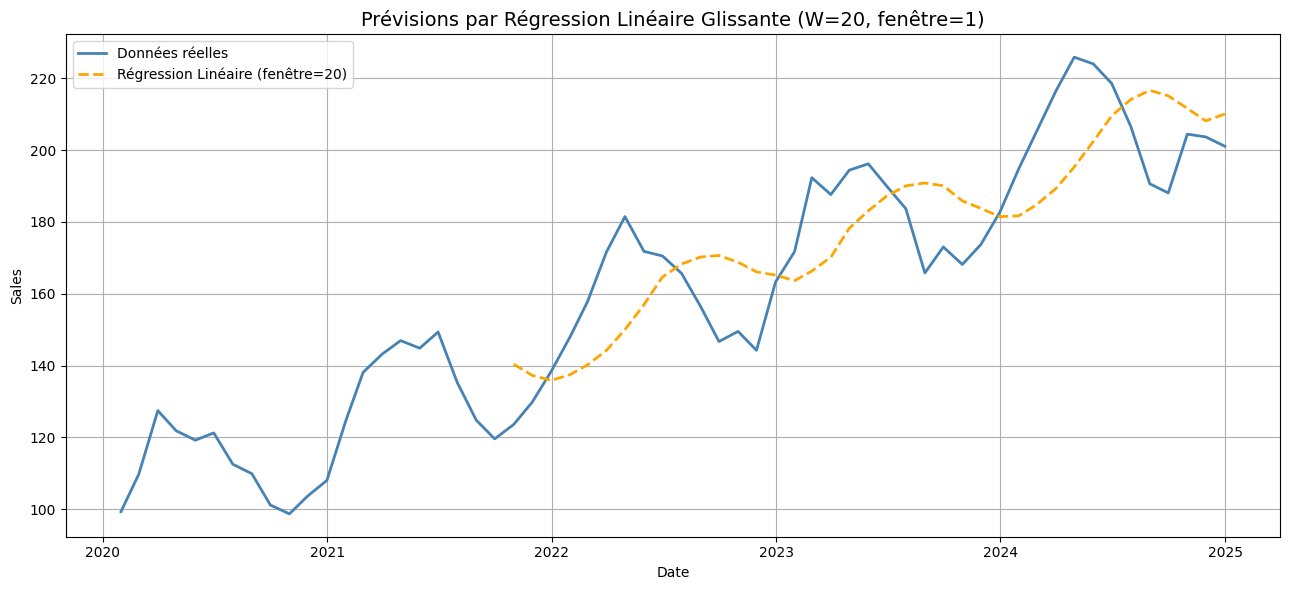

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ----------------------------------
# Données (tu as déjà 'data' avec data['Sales'])
# ----------------------------------
sales = data['Sales'].values
n = len(sales)

window = 20          # taille de la fenêtre
lookahead = 1        # prédire t+1

rolling_preds = []
rolling_dates = []

# ----------------------------------
# Rolling Linear Regression (fenêtre = 20)
# ----------------------------------
for t in range(window, n - lookahead):
    # Fenêtre des 20 points précédents
    y_window = sales[t-window:t]

    # Feature temporelle locale = 0..19
    X_window = np.arange(window).reshape(-1, 1)

    # Fit modèle local
    model = LinearRegression()
    model.fit(X_window, y_window)

    # Feature pour prédire le point suivant (20)
    X_next = np.array([[window]])
    pred = model.predict(X_next)[0]

    rolling_preds.append(pred)
    rolling_dates.append(data['Date'].iloc[t + lookahead])

# Convertir en DataFrame
rolling_df = pd.DataFrame({
    'Date': rolling_dates,
    'LinearRolling': rolling_preds
})

# ----------------------------------
# Plot : Réel vs Rolling Linear Regression
# ----------------------------------
plt.figure(figsize=(13,6))

plt.plot(data['Date'], data['Sales'], label='Données réelles', color='steelblue', linewidth=2)
plt.plot(rolling_df['Date'], rolling_df['LinearRolling'],
         label='Régression Linéaire (fenêtre=20)', color='orange', linestyle='--', linewidth=2)

plt.title("Prévisions par Régression Linéaire Glissante (W=20, fenêtre=1)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
import tensorflow as tf

def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
    series = tf.cast(series, tf.float32)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

def window_dataset_val(series, window_size, batch_size=32):
    """Version validation : identique mais **sans** shuffle (ordre conservé)."""
    series = tf.cast(series, tf.float32)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # pas de shuffle ici
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [8]:
def train_and_evaluate_model(data, model, train_size_ratio, feature_col, time_feature_type):
    # 1. Calculate train_size
    train_size = int(train_size_ratio * len(data))

    # 2. Split data into train and test DataFrames
    train = data.iloc[:train_size]
    test = data.iloc[train_size:]

    # 3. Extract target variables
    y_train = train[feature_col]
    y_test = test[feature_col]

    # 4. Generate feature matrices based on time_feature_type
    X_train = None
    X_test = None

    if time_feature_type == 'time_index':
        X_train = np.arange(len(train)).reshape(-1, 1)
        X_test = np.arange(len(train), len(data)).reshape(-1, 1)

    # For now, return the processed data and features. Model training and evaluation will be added later.
    return train, test, X_train, y_train, X_test, y_test

print("Function 'train_and_evaluate_model' defined.")

Function 'train_and_evaluate_model' defined.


### Préparation des données pour le Modèle LSTM

Nous allons définir la taille de la fenêtre (`window_size`) pour le modèle LSTM, puis préparer les jeux de données d'entraînement et de validation en utilisant les fonctions `window_dataset` et `window_dataset_val`.

Nous prendrons la colonne 'Sales' de notre jeu de données `data` existant, la diviserons en ensembles d'entraînement et de test, et construirons des fenêtres temporelles pour l'entraînement du LSTM.

In [11]:
import numpy as np
import pandas as pd

# ----------------------------------------------------
# 🔹 Données (re-définition pour assurer la disponibilité)
# Cette partie est dupliquée d'une cellule précédente pour s'assurer que 'data' est définie
# en cas de redémarrage du noyau ou d'exécution hors-séquence.
# ----------------------------------------------------
n = 60           # 5 ans mensuels
t = np.arange(n)
beta0 = 100
beta1 = 2
A = 20
P = 12
sigma = 5

trend = beta0 + beta1 * t
seasonality = A * np.sin(2 * np.pi * t / P)
noise = np.random.normal(0, sigma, n)
sales = trend + seasonality + noise

dates = pd.date_range(start='2020-01-01', periods=n, freq='ME')
data = pd.DataFrame({'Date': dates, 'Sales': sales})

# Définir la taille de la fenêtre pour le LSTM
window_size = 24  # Par exemple, pour capturer 2 ans de données mensuelles ou une saisonnalité

# Utiliser le découpage train/test existant du DataFrame 'data'
# (Assumant que 'data' est déjà défini et contient 'Sales')
train_size_ratio = 0.8
train_size = int(train_size_ratio * len(data))

series = data['Sales'].values
series_train = series[:train_size]
series_test = series[train_size:]

# Préparer les jeux de données fenêtrés pour l'entraînement et la validation (à partir de series_train)
# Nous divisons series_train en train_sequence et valid_sequence pour l'entraînement du LSTM
# Un split 80/20 de series_train est un bon point de départ pour la validation interne pendant l'entraînement
len_train_seq = int(0.8 * len(series_train))
train_sequence = series_train[:len_train_seq]
valid_sequence = series_train[len_train_seq:]

train_set = window_dataset(train_sequence, window_size, batch_size=32)
valid_set = window_dataset_val(valid_sequence, window_size, batch_size=32)

print(f"Taille de la fenêtre LSTM: {window_size}")
print(f"Nombre d'éléments pour l'entraînement (LSTM): {len(train_sequence)}")
print(f"Nombre d'éléments pour la validation (LSTM): {len(valid_sequence)}")


Taille de la fenêtre LSTM: 24
Nombre d'éléments pour l'entraînement (LSTM): 38
Nombre d'éléments pour la validation (LSTM): 10


### Création et Entraînement du Modèle LSTM

Maintenant que les données sont préparées, nous allons créer une instance du modèle Bidirectionnel LSTM et l'entraîner sur notre jeu de données d'entraînement.

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense

# Definition of create_bidirectional_lstm_model (duplicated to ensure availability)
# Cette partie est dupliquée d'une cellule précédente pour s'assurer que 'create_bidirectional_lstm_model' est définie
# en cas de redémarrage du noyau ou d'exécution hors-séquence.
def create_bidirectional_lstm_model(window_size):
    model = Sequential([
        Bidirectional(LSTM(32, return_sequences=False), input_shape=[window_size, 1]),
        Dense(1)
    ])
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    return model

# Créer le modèle LSTM
lstm_model = create_bidirectional_lstm_model(window_size)
lstm_model.summary()

# Entraîner le modèle
history = lstm_model.fit(
    train_set,
    epochs=20,  # Nombre d'époques, peut être ajusté
    validation_data=valid_set,
    verbose=1
)

print("Entraînement du modèle LSTM terminé.")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 64)             │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,769 (34.25 KB)

 Trainable params: 8,769 (34.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
      1/Unknown 4s 4s/step - loss: 25884.6973 - mae: 160.4129

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 25884.6973 - mae: 160.4129
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 25871.8262 - mae: 160.3728
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 25860.6895 - mae: 160.3380
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 25849.5215 - mae: 160.3031
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 25838.0273 - mae: 160.2672
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 25826.0977 - mae: 160.2299
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 25813.6602 - mae: 160.1911
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 25800.6914 - mae: 160.1505
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 25787.4434 - mae: 160.1091
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 25773.9824 - mae: 160.0670
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 25760.3848 - mae: 160.0245
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 25746.8262 - mae: 159.9821
E

### Sauvegarde du Modèle LSTM

Nous allons sauvegarder le modèle LSTM entraîné afin de pouvoir le réutiliser plus tard sans avoir à le réentraîner.

In [14]:
import os

# Définir le chemin de sauvegarde du modèle
model_save_path = 'lstm_model.keras'

# Sauvegarder le modèle
lstm_model.save(model_save_path)

print(f"Modèle LSTM sauvegardé avec succès sous : {model_save_path}")


Modèle LSTM sauvegardé avec succès sous : lstm_model.keras


### Évaluation du Modèle LSTM

Pour évaluer le modèle LSTM sur l'ensemble de test, nous allons utiliser une approche de prédiction itérative. Le modèle prédira une valeur à la fois, en utilisant la séquence de données précédente. Pour une évaluation juste, nous alimenterons le modèle avec les *vraies* valeurs de l'ensemble de test à chaque étape pour prédire la suivante, garantissant ainsi que l'erreur ne se propage pas à cause de prédictions antérieures incorrectes.

📊 ÉVALUATION DU MODÈLE LSTM
--------------------------------------
MAE  : 207.81
RMSE : 208.16
MAPE : 99.76%


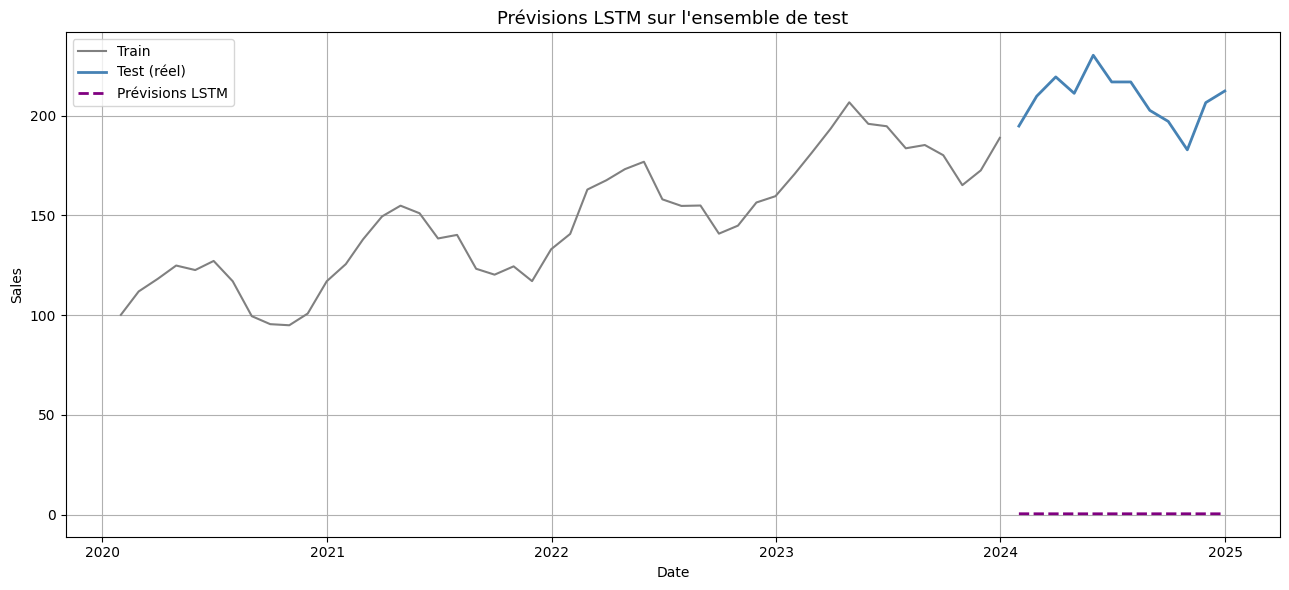

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Redéfinition de la fonction metrics pour s'assurer qu'elle est disponible
def metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    # Éviter la division par zéro dans MAPE si 'true' contient des zéros
    # Ou gérer les cas où les vraies valeurs sont très petites, ce qui peut rendre MAPE instable.
    # Pour des valeurs positives et non nulles, ceci fonctionne.
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return mae, rmse, mape

# --- 1. Préparation des données pour la prédiction ---
# Récupérer les dernières `window_size` valeurs de l'entraînement pour initialiser la prédiction
# Assurez-vous que series_train et series_test sont des ndarray
series_train_arr = np.array(series_train)
series_test_arr = np.array(series_test)

last_window_from_train = series_train_arr[-window_size:]

# Initialiser la séquence pour la prédiction avec la dernière fenêtre de l'entraînement
current_input_sequence = last_window_from_train.tolist()
lstm_predictions = []

# --- 2. Prédiction itérative sur l'ensemble de test ---
for i in range(len(series_test_arr)):
    # Reshape l'entrée pour le modèle LSTM (batch_size, window_size, features)
    input_for_model = np.array(current_input_sequence).reshape(1, window_size, 1)

    # Faire une prédiction (le modèle prédit la prochaine valeur après la séquence d'entrée)
    next_prediction = lstm_model.predict(input_for_model, verbose=0)[0][0]
    lstm_predictions.append(next_prediction)

    # Mettre à jour la séquence d'entrée pour la prochaine prédiction
    # On utilise la VRAIE valeur du test pour la prochaine prédiction
    # C'est important pour évaluer la performance du modèle sur chaque pas de temps
    # sans que les erreurs de prédiction précédentes ne s'accumulent.
    current_input_sequence.pop(0) # Supprimer la plus ancienne valeur
    current_input_sequence.append(series_test_arr[i]) # Ajouter la vraie valeur suivante du test

# Convertir les prédictions en array numpy pour le calcul des métriques
lstm_predictions = np.array(lstm_predictions)

# --- 3. Évaluation des métriques ---
mae_lstm, rmse_lstm, mape_lstm = metrics(series_test_arr, lstm_predictions)

print("📊 ÉVALUATION DU MODÈLE LSTM")
print("--------------------------------------")
print(f"MAE  : {mae_lstm:.2f}")
print(f"RMSE : {rmse_lstm:.2f}")
print(f"MAPE : {mape_lstm:.2f}%")

# --- 4. Visualisation des prévisions ---
plt.figure(figsize=(13,6))

# Données d'entraînement
plt.plot(data['Date'].iloc[:train_size], series_train, label='Train', color='gray')

# Données réelles du test
test_dates = data['Date'].iloc[train_size:train_size + len(series_test_arr)]
plt.plot(test_dates, series_test_arr, label='Test (réel)', color='steelblue', linewidth=2)

# Prévisions LSTM
plt.plot(test_dates, lstm_predictions, label='Prévisions LSTM', color='purple', linestyle='--', linewidth=2)

plt.title("Prévisions LSTM sur l'ensemble de test", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()